# <b>EDA 학습 과제 2</b>
## 주유소 데이터 분석 과제

In [28]:
# requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc

get_ipython().run_line_magic("matplotlib", "inline")
%matplotlib inline

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

## 조건)
서울시 구별 주유소 데이터 정보를 엑셀 파일 다운로드가 아닌, 크롤링 코드로 데이터를 수집

---
## 문제 1) 
### 수집한 데이터들을 pandas 데이터 프레임으로 정리해주세요. 부가 정보 데이터는 셀프 여부와 마찬가지로 Y 또는 N으로 저장해주세요. 최종적으로 데이터 프레임에 들어가야할 컬럼은 총 14개로 아래와 같습니다.
- 주요소명, 주소, 브랜드, 휘발유 가격, 경유 가격, 셀프 여부, 세차장 여부, 충전소 여부, 경정비 여부, 편의점 여부, 24시간 운영 여부, 구, 위도, 경도
- 주유 가격 사이트 url: https://www.opinet.co.kr/searRgSelect.do

In [29]:
# selenium webdriver로 url 접근
from selenium import webdriver

driver = webdriver.Chrome()
driver.get("https://www.opinet.co.kr/searRgSelect.do")

In [30]:
# 지역의 시,도 태그 찾기
from selenium.webdriver.common.by import By

sido_list_raw = driver.find_element(By.ID, "SIDO_NM0")

In [31]:
# 시,도 태그에서 "서울"을 찾아 선택
sido_list = sido_list_raw.find_elements(By.TAG_NAME, "option")
sido_names = [option.get_attribute("value") for option in sido_list]

# sido_list의 첫번째 값은 "시/도"이므로 sido_names에서 제외
sido_names = sido_names[1:]

# sido_names[0] = '서울특별시'
sido_list_raw.send_keys(sido_names[0])

In [32]:
# 시/군/구 값 추출
gu_list_raw = driver.find_element(By.ID, "SIGUNGU_NM0")
gu_list = gu_list_raw.find_elements(By.TAG_NAME, "option")

gu_names = [option.get_attribute("value") for option in gu_list]
gu_names = gu_names[1:]

gu_names

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

- 엑셀 저장 버튼을 누르지 않고 데이터를 크롤링해야함
- 순서
    - 1. 서울시 각 구 선택 후 조회 버튼 클릭
    - 2. html 파싱
    - 3. 검색결과 개수(=주유소 개수) 만큼 반복
    - 3. 주유소 이름, 주소, 브랜드, 휘발유 가격(보통휘발유), 경유 가격, 셀프 여부, 세차장 여부, 충전소 여부, 경정비 여부, 편의점 여부, 24시간 운영 여부, 구, 위도, 경도 추출 

In [60]:
import time
import pandas as pd
from bs4 import BeautifulSoup as bs
from tqdm import tqdm

station_datas = []

for gu in tqdm(gu_names) :
    # 시/군/구 태그 선택
    gu_element = driver.find_element(By.ID, "SIGUNGU_NM0")
    gu_element.send_keys(gu)
    time.sleep(1)

    # 시/군/구 선택 시 결과 화면 html 파싱
    html = driver.page_source
    soup = bs(html, "html.parser")

    # 검색결과 수만큼 반복
    station_cnt = int(soup.select_one('#totCnt').text)
    for i in range(1, station_cnt+1) :    #nth_child는 1부터 시작하므로 i를 1부터
        
        each_data = {}
        
        each_station = driver.find_element(By.CSS_SELECTOR, f" #body1 > tr:nth-child({i}) > td.rlist > a")
        each_station.click()
        time.sleep(1)

        # 각 주유소 정보 화면에 대한 html 파싱
        html = driver.page_source
        soup = bs(html, "html.parser")

        # 주유소명
        station_name = soup.select_one("#os_nm").text

        # 주소
        station_address = soup.select_one("#rd_addr").text

        # 브랜드
        station_brand = soup.select_one("#poll_div_nm").text

        # 휘발유 가격(보통휘발유)
        gasoline_price = soup.select_one("#b027_p").text

        # 경유 가격
        diesel_price = soup.select_one("#d047_p").text

        # 셀프 여부
        self_yn = "Y" if soup.find(class_="header").find(id = "SPAN_SELF_VLT_YN_ID").find(id = "self_icon") else "N"

        # 세차장 여부
        wash_yn = "Y" if "off" not in soup.select_one("#cwsh_yn")['src'] else "N"

        # 충전소 여부
        lpg_yn = "Y" if "off" not in soup.select_one("#lpg_yn")['src'] else "N"

        # 경정비 여부
        maint_yn = "Y" if "off" not in soup.select_one("#maint_yn")['src'] else "N"

        # 편의점 여부
        cvs_yn = "Y" if "off" not in soup.select_one("#cvs_yn")['src'] else "N"

        # 24시간 여부
        sel24_yn = "Y" if "off" not in soup.select_one("#sel24_yn")['src'] else "N"

        each_data = {
            '주유소명' : station_name,
            '주소' : station_address,
            '브랜드' : station_brand,
            '휘발유 가격' : gasoline_price,
            '경유 가격' : diesel_price,
            '셀프 여부' : self_yn,
            '세차장 여부' : wash_yn,
            '충전소 여부' : lpg_yn,
            '경정비 여부' : maint_yn,
            '편의점 여부' : cvs_yn,
            '25시간 운영 여부' : sel24_yn
        }

        station_datas.append(each_data)

100%|██████████| 25/25 [09:13<00:00, 22.16s/it]


In [107]:
driver.close()

In [132]:
# 데이터프레임 생성
station_df = pd.DataFrame(station_datas)

station_df.head()

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부
0,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,583","1,428",Y,Y,N,N,N,N
1,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,595","1,428",Y,Y,N,N,N,N
2,HD현대오일뱅크㈜직영 강남셀프주유소,서울 강남구 도곡로 208,HD현대오일뱅크,"1,619","1,504",Y,Y,N,N,N,N
3,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),SK에너지,"1,626","1,516",Y,Y,N,Y,N,Y
4,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,627","1,469",Y,Y,N,N,N,N


- 1,2행의 주유소명에 브랜드 이름이 합쳐져있어서 확인해보니, 실제 주유소 이름이 저렇게 되어있었다.
- 코드 짜고 실행하는데 엄청 오래 걸렸는데 식겁했다..

In [133]:
station_df.tail()

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부
420,(주)태영 구도일주유소 한인,서울 중랑구 망우로 170 (상봉동),S-OIL,"1,597","1,397",Y,Y,N,Y,N,N
421,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,"1,599","1,432",Y,Y,N,N,N,N
422,범아주유소,서울 중랑구 동일로 881 (묵동),S-OIL,"1,609","1,439",N,Y,N,Y,N,N
423,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,"1,698","1,498",Y,Y,N,N,N,N
424,신일셀프주유소,서울 중랑구 상봉로 58 (망우동),SK에너지,"1,698","1,598",Y,Y,N,Y,N,Y


In [134]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   주유소명        425 non-null    object
 1   주소          425 non-null    object
 2   브랜드         425 non-null    object
 3   휘발유 가격      425 non-null    object
 4   경유 가격       425 non-null    object
 5   셀프 여부       425 non-null    object
 6   세차장 여부      425 non-null    object
 7   충전소 여부      425 non-null    object
 8   경정비 여부      425 non-null    object
 9   편의점 여부      425 non-null    object
 10  25시간 운영 여부  425 non-null    object
dtypes: object(11)
memory usage: 36.6+ KB


- 구, 위도, 경도 추가

In [135]:
# 구 추가
gu_datas = []
for idx, row in station_df.iterrows() :
    gu_datas.append(row['주소'].split()[1])

station_df['구'] = gu_datas

station_df.head()

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부,구
0,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,583","1,428",Y,Y,N,N,N,N,강남구
1,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,595","1,428",Y,Y,N,N,N,N,강남구
2,HD현대오일뱅크㈜직영 강남셀프주유소,서울 강남구 도곡로 208,HD현대오일뱅크,"1,619","1,504",Y,Y,N,N,N,N,강남구
3,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),SK에너지,"1,626","1,516",Y,Y,N,Y,N,Y,강남구
4,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,627","1,469",Y,Y,N,N,N,N,강남구


In [136]:
station_df.tail()

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부,구
420,(주)태영 구도일주유소 한인,서울 중랑구 망우로 170 (상봉동),S-OIL,"1,597","1,397",Y,Y,N,Y,N,N,중랑구
421,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,"1,599","1,432",Y,Y,N,N,N,N,중랑구
422,범아주유소,서울 중랑구 동일로 881 (묵동),S-OIL,"1,609","1,439",N,Y,N,Y,N,N,중랑구
423,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,"1,698","1,498",Y,Y,N,N,N,N,중랑구
424,신일셀프주유소,서울 중랑구 상봉로 58 (망우동),SK에너지,"1,698","1,598",Y,Y,N,Y,N,Y,중랑구


In [138]:
# 위도, 경도 추가
# google map api를 호출하여 각 주유소별 위도, 경도값 가져오기
import googlemaps

gmaps_key = "<gmaps api key>"
gmaps = googlemaps.Client(gmaps_key)

lat = []
lng = []

for idx, row in tqdm(station_df.iterrows()) :
    tmp = gmaps.geocode(row['주소'], language='ko')
    if tmp :
        lat.append(tmp[0].get('geometry')['location']['lat'])
        lng.append(tmp[0].get('geometry')['location']['lng'])
    else :
        lat.append(np.nan)
        lng.append(np.nan)

station_df['위도'] = lat
station_df['경도'] = lng

425it [00:58,  7.24it/s]


In [139]:
station_df

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부,구,위도,경도
0,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,583","1,428",Y,Y,N,N,N,N,강남구,37.467157,127.118708
1,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,595","1,428",Y,Y,N,N,N,N,강남구,37.466567,127.119080
2,HD현대오일뱅크㈜직영 강남셀프주유소,서울 강남구 도곡로 208,HD현대오일뱅크,"1,619","1,504",Y,Y,N,N,N,N,강남구,37.492295,127.041860
3,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),SK에너지,"1,626","1,516",Y,Y,N,Y,N,Y,강남구,37.485839,127.039672
4,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,627","1,469",Y,Y,N,N,N,N,강남구,37.474993,127.106887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,(주)태영 구도일주유소 한인,서울 중랑구 망우로 170 (상봉동),S-OIL,"1,597","1,397",Y,Y,N,Y,N,N,중랑구,37.592466,127.071908
421,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,"1,599","1,432",Y,Y,N,N,N,N,중랑구,37.617125,127.095896
422,범아주유소,서울 중랑구 동일로 881 (묵동),S-OIL,"1,609","1,439",N,Y,N,Y,N,N,중랑구,37.609311,127.077673
423,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,"1,698","1,498",Y,Y,N,N,N,N,중랑구,37.579878,127.092182


In [140]:
# 데이터 저장
station_df.to_csv('Seoul_Oil_Station.csv', sep=',', encoding='utf-8')

---
## 문제 2) 
### 휘발유와 경유 가격이 셀프 주유소에서 정말 저렴한지 분석 결과를 작성

In [144]:
# 데이터 불러오기
station_df = pd.read_csv('Seoul_Oil_Station.csv', thousands=',', encoding='utf-8')

del station_df['Unnamed: 0']

station_df.head()

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부,구,위도,경도
0,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,1583,1428,Y,Y,N,N,N,N,강남구,37.467157,127.118708
1,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,1595,1428,Y,Y,N,N,N,N,강남구,37.466567,127.119080
2,HD현대오일뱅크㈜직영 강남셀프주유소,서울 강남구 도곡로 208,HD현대오일뱅크,1619,1504,Y,Y,N,N,N,N,강남구,37.492295,127.041860
3,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),SK에너지,1626,1516,Y,Y,N,Y,N,Y,강남구,37.485839,127.039672
4,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,1627,1469,Y,Y,N,N,N,N,강남구,37.474993,127.106887


#### 1. 데이터프레임으로 분석
- 간단하게 각 휘발유, 경유값이 가장 비싼 10개 주유소와 가장 저렴한 10개 주유소로 정렬하여 비교해보자

In [145]:
gasoline_top_five = station_df.sort_values(by='휘발유 가격', ascending=False)
gasoline_top_five.head(10)

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부,구,위도,경도
379,서계주유소,서울 용산구 청파로 367 (청파동),GS칼텍스,2829,2799,N,Y,N,N,N,N,용산구,37.552329,126.968946
412,서남주유소,서울 중구 통일로 30,SK에너지,2608,2472,N,Y,N,N,N,Y,중구,37.558375,126.972094
29,(주)만정에너지 삼보주유소,서울 강남구 봉은사로 433 (삼성동),GS칼텍스,2593,2555,N,Y,N,N,N,N,강남구,37.511521,127.047172
28,(주)제이제이네트웍스 제이제이주유소,서울 강남구 언주로 716,HD현대오일뱅크,2458,2248,N,Y,N,N,N,Y,강남구,37.517647,127.035735
411,필동주유소,서울 중구 퇴계로 196 (필동2가),GS칼텍스,2389,2239,N,N,N,N,N,Y,중구,37.558773,126.994721
367,SJ오일(주) 여의도주유소,서울 영등포구 은행로 64,GS칼텍스,2295,2395,N,Y,Y,N,Y,Y,영등포구,37.530380,126.925578
378,한남지점,서울 용산구 한남대로21길 4 (한남동),SK에너지,2287,2177,N,N,N,N,N,N,용산구,37.534733,127.006095
377,에너비스,서울 용산구 한남대로 82 (한남동),SK에너지,2287,2177,N,Y,N,N,N,N,용산구,37.536041,127.006128
27,SK논현주유소,서울 강남구 논현로 747 (논현동),SK에너지,2285,2095,N,Y,N,Y,N,Y,강남구,37.518637,127.028238
402,(주)대양씨앤씨 사직주유소,서울 종로구 사직로 65 (사직동),GS칼텍스,2265,2115,N,N,N,N,N,N,종로구,37.574505,126.966607


- 휘발유 값이 가장 비싼 10개의 주유소 모두 셀프주유소가 아님을 확인했다

In [146]:
diesel_top_five = station_df.sort_values(by='경유 가격', ascending=False)
diesel_top_five.head(10)

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부,구,위도,경도
379,서계주유소,서울 용산구 청파로 367 (청파동),GS칼텍스,2829,2799,N,Y,N,N,N,N,용산구,37.552329,126.968946
29,(주)만정에너지 삼보주유소,서울 강남구 봉은사로 433 (삼성동),GS칼텍스,2593,2555,N,Y,N,N,N,N,강남구,37.511521,127.047172
412,서남주유소,서울 중구 통일로 30,SK에너지,2608,2472,N,Y,N,N,N,Y,중구,37.558375,126.972094
367,SJ오일(주) 여의도주유소,서울 영등포구 은행로 64,GS칼텍스,2295,2395,N,Y,Y,N,Y,Y,영등포구,37.530380,126.925578
28,(주)제이제이네트웍스 제이제이주유소,서울 강남구 언주로 716,HD현대오일뱅크,2458,2248,N,Y,N,N,N,Y,강남구,37.517647,127.035735
411,필동주유소,서울 중구 퇴계로 196 (필동2가),GS칼텍스,2389,2239,N,N,N,N,N,Y,중구,37.558773,126.994721
366,SK KH에너지 여의도주유소,서울 영등포구 국회대로 794 (여의도동),SK에너지,2195,2189,N,Y,N,N,N,N,영등포구,37.530794,126.920390
377,에너비스,서울 용산구 한남대로 82 (한남동),SK에너지,2287,2177,N,Y,N,N,N,N,용산구,37.536041,127.006128
378,한남지점,서울 용산구 한남대로21길 4 (한남동),SK에너지,2287,2177,N,N,N,N,N,N,용산구,37.534733,127.006095
402,(주)대양씨앤씨 사직주유소,서울 종로구 사직로 65 (사직동),GS칼텍스,2265,2115,N,N,N,N,N,N,종로구,37.574505,126.966607


- 경유도 마찬가지로 가장 비싼 주유소 10개 모두 셀프주유소가 아니다.

In [147]:
gasoline_top_five.tail(10)

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부,구,위도,경도
384,불광주유소,서울 은평구 연서로 314 (불광동),HD현대오일뱅크,1527,1415,Y,Y,N,N,N,N,은평구,37.620397,126.923768
382,타이거주유소,서울 은평구 수색로 188 (증산동),SK에너지,1524,1404,Y,Y,N,N,N,N,은평구,37.585148,126.904152
54,(주)타이거오일 방화주유소,서울 강서구 방화동로 58-2 (방화동),SK에너지,1524,1373,Y,N,N,N,N,N,강서구,37.565627,126.812408
319,(주)타이거오일 신정주유소,서울 양천구 중앙로 226 (신정동),SK에너지,1524,1369,Y,N,N,N,N,N,양천구,37.516802,126.854664
381,㈜한화미 구파발주유소,서울 은평구 통일로 1031,S-OIL,1524,1394,Y,N,N,N,N,N,은평구,37.643474,126.917372
383,지에스칼텍스(주)수색뉴타운주유소,서울 은평구 수색로 350 (수색동),GS칼텍스,1524,1404,Y,Y,N,N,N,N,은평구,37.587171,126.887539
318,현대주유소,서울 양천구 남부순환로 372 (신월동),S-OIL,1523,1357,Y,Y,N,N,N,N,양천구,37.533873,126.829262
317,플라트(주)서호주유소,서울 양천구 남부순환로 317,GS칼텍스,1523,1357,Y,Y,N,Y,N,N,양천구,37.538661,126.826837
53,화곡역주유소,서울 강서구 강서로 154 (화곡동),알뜰주유소,1523,1357,Y,N,N,N,N,Y,강서구,37.540719,126.841530
380,(주)디오티디 은평유니콘주유소,서울 은평구 통일로 1151 (진관동),HD현대오일뱅크,1514,1344,N,Y,N,N,N,N,은평구,37.643226,126.920007


- 휘발유 가격이 가장 저렴한 주유소는 놀랍게도 셀프주유소가 아니다.
- 하지만 나머지 9개의 주유소는 모두 셀프주유소이다.

In [148]:
diesel_top_five.tail(10)

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,25시간 운영 여부,구,위도,경도
345,(주)대청에너지 대청주유소,서울 영등포구 가마산로 328 (대림동),GS칼텍스,1535,1360,Y,Y,N,Y,N,Y,영등포구,37.498547,126.895759
344,영등포현대셀프주유소,서울 영등포구 경인로 822 (영등포동),HD현대오일뱅크,1535,1360,Y,N,N,N,Y,N,영등포구,37.515340,126.904490
343,한경석유(주)경덕주유소,서울 영등포구 여의대방로23길 2 (신길동),SK에너지,1535,1360,Y,Y,N,N,N,N,영등포구,37.517697,126.916997
342,성락주유소,서울 영등포구 가마산로 414 (신길동),S-OIL,1535,1360,Y,Y,N,N,N,N,영등포구,37.503825,126.902869
341,영등포제일셀프주유소,서울 영등포구 가마산로 379,HD현대오일뱅크,1535,1360,Y,Y,N,Y,N,N,영등포구,37.502348,126.899503
318,현대주유소,서울 양천구 남부순환로 372 (신월동),S-OIL,1523,1357,Y,Y,N,N,N,N,양천구,37.533873,126.829262
317,플라트(주)서호주유소,서울 양천구 남부순환로 317,GS칼텍스,1523,1357,Y,Y,N,Y,N,N,양천구,37.538661,126.826837
53,화곡역주유소,서울 강서구 강서로 154 (화곡동),알뜰주유소,1523,1357,Y,N,N,N,N,Y,강서구,37.540719,126.841530
219,만남의광장주유소,서울 서초구 양재대로12길 73-71,알뜰(ex),1529,1347,Y,N,Y,N,Y,Y,서초구,37.460084,127.042169
380,(주)디오티디 은평유니콘주유소,서울 은평구 통일로 1151 (진관동),HD현대오일뱅크,1514,1344,N,Y,N,N,N,N,은평구,37.643226,126.920007


- 경유 가격이 가장 저렴한 주유소 또한 셀프주유소가 아니다.
- 나머지 9개 주유소는 모두 셀프주유소이다.

#### 2. 시각화를 통한 분석

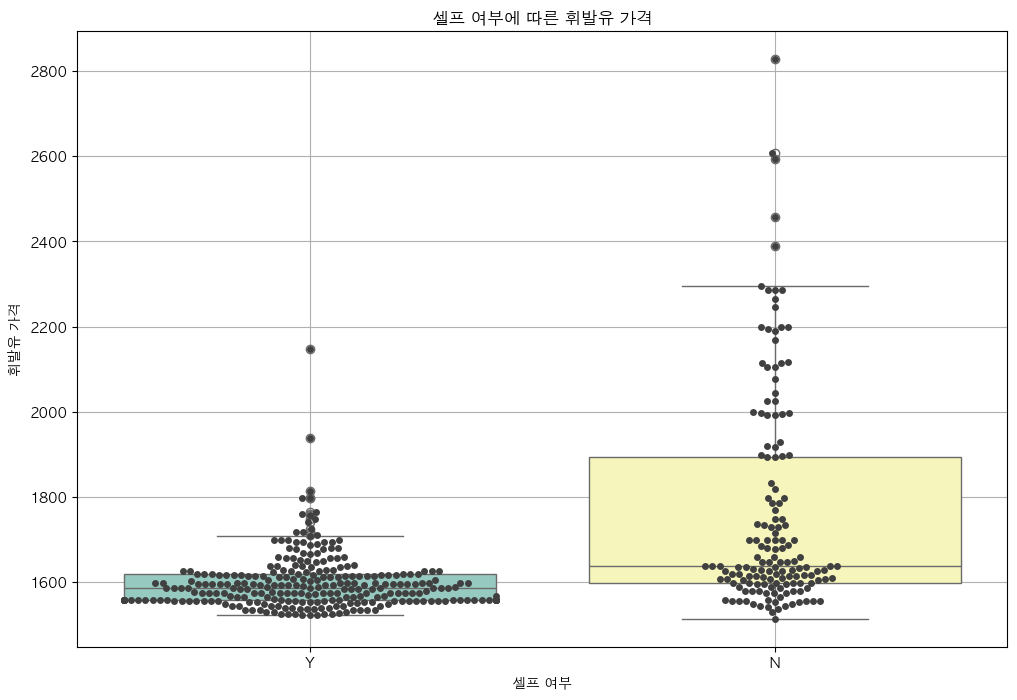

In [158]:
# boxplot + swarmplot
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

# 휘발유 가격 비교
plt.figure(figsize=(12, 8))
sns.boxplot(x="셀프 여부", y="휘발유 가격", data=station_df, palette="Set3", hue='셀프 여부')
sns.swarmplot(x='셀프 여부', y="휘발유 가격", data=station_df, color='0.25')
plt.title('셀프 여부에 따른 휘발유 가격')
plt.grid(True)
plt.show()

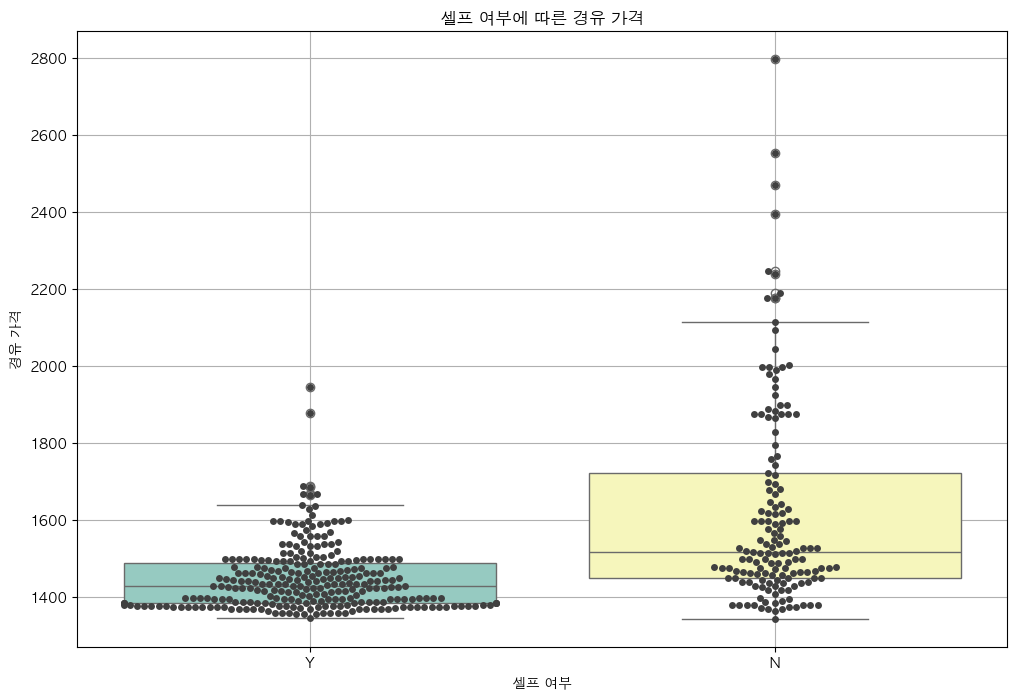

In [159]:
# 경유 가격 비교
plt.figure(figsize=(12, 8))
sns.boxplot(x="셀프 여부", y="경유 가격", data=station_df, palette="Set3", hue='셀프 여부')
sns.swarmplot(x='셀프 여부', y="경유 가격", data=station_df, color='0.25')
plt.title('셀프 여부에 따른 경유 가격')
plt.grid(True)
plt.show()

- boxplot을 확인한 결과, 휘발유, 경유 모두 셀프주유소 가격이 더 저렴한 것을 확인할 수 있다.
- 또한 swarmplot의 결과 셀프주유소의 경우 가격 분포가 가장 저렴한 가격에 많이 치우쳐져있음을 확인하였다. 이는 서울시 대부분의 셀프주유소 가격이 가장 저렴한 가격대에 많이 형성되어 있음을 알 수 있다.
- 일반주유소도 일반주유소 가격 중 저렴한 가격대에 가격 분포가 많이 형성되어 있지만, 셀프주유소에 비해 가격분포가 조금 더 균일함을 확인할 수 있다.

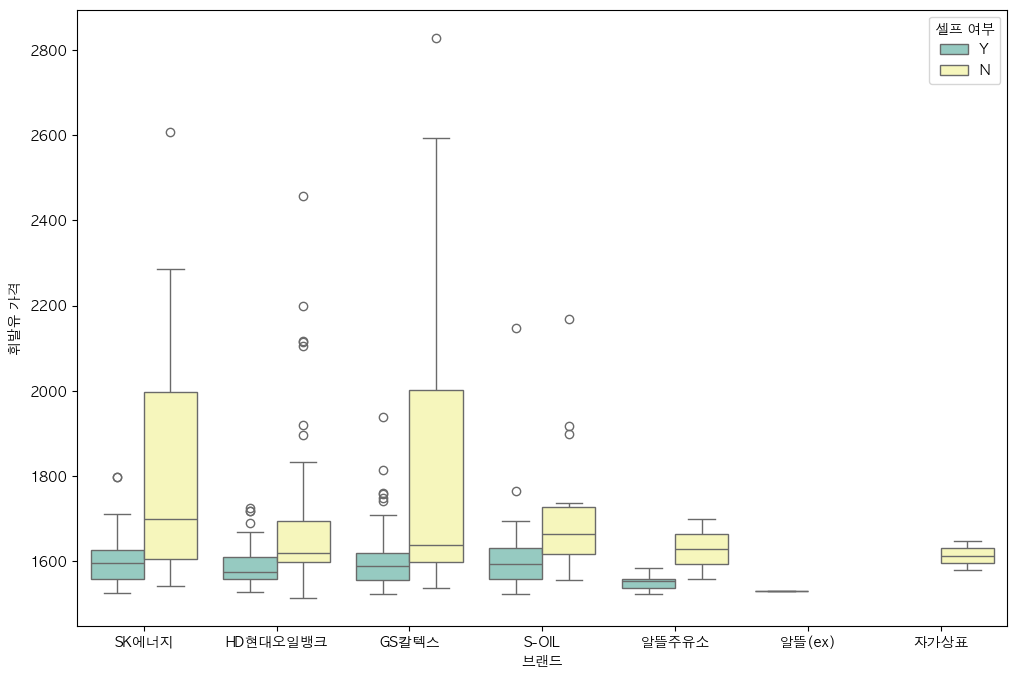

In [156]:
# 브랜드별 휘발유 가격
plt.figure(figsize=(12, 8))
sns.boxplot(x='브랜드', y='휘발유 가격', data=station_df, palette='Set3', hue='셀프 여부')
plt.show()

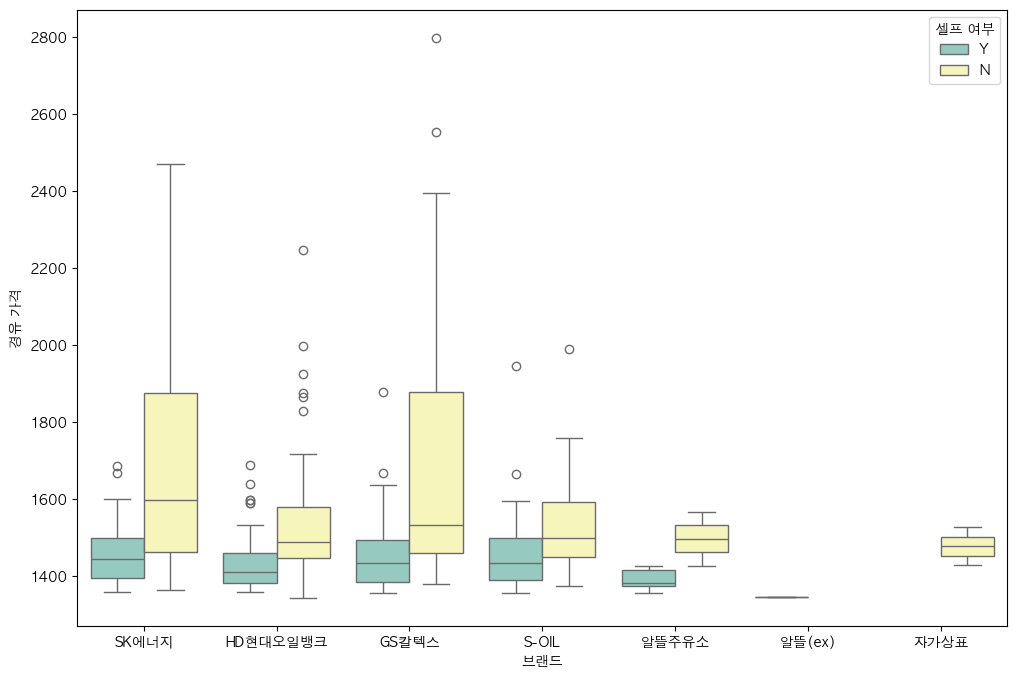

In [157]:
# 브랜드별 경유 가격
plt.figure(figsize=(12, 8))
sns.boxplot(x='브랜드', y='경유 가격', data=station_df, palette='Set3', hue='셀프 여부')
plt.show()

- 주유소 브랜드별로 비교하였을 때, 각 브랜드별로도 셀프주유소가 일반주유소보다 저렴한 것을 알 수 있었다.
- 알뜰 주유소를 제외하고 HD 현대오일뱅크의 셀프 및 일반주유소의 가격이 가장 저렴하다.

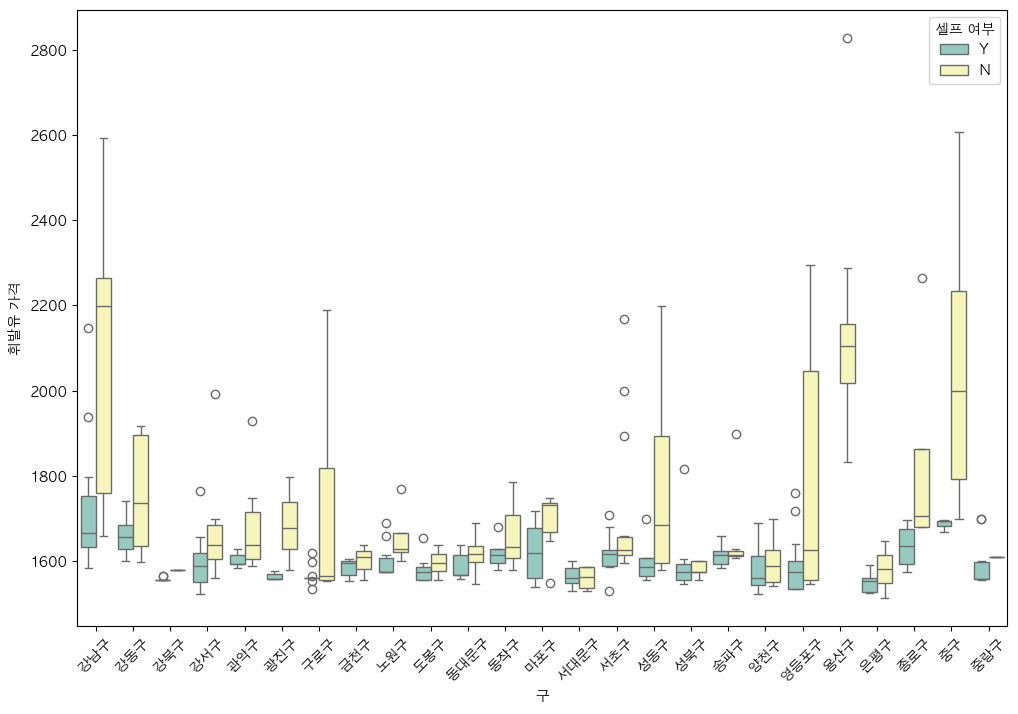

In [161]:
# 구별 휘발유 가격
plt.figure(figsize=(12, 8))
sns.boxplot(x='구', y='휘발유 가격', data=station_df, palette='Set3', hue='셀프 여부')
_, xlabels = plt.xticks(rotation=45)
plt.show()

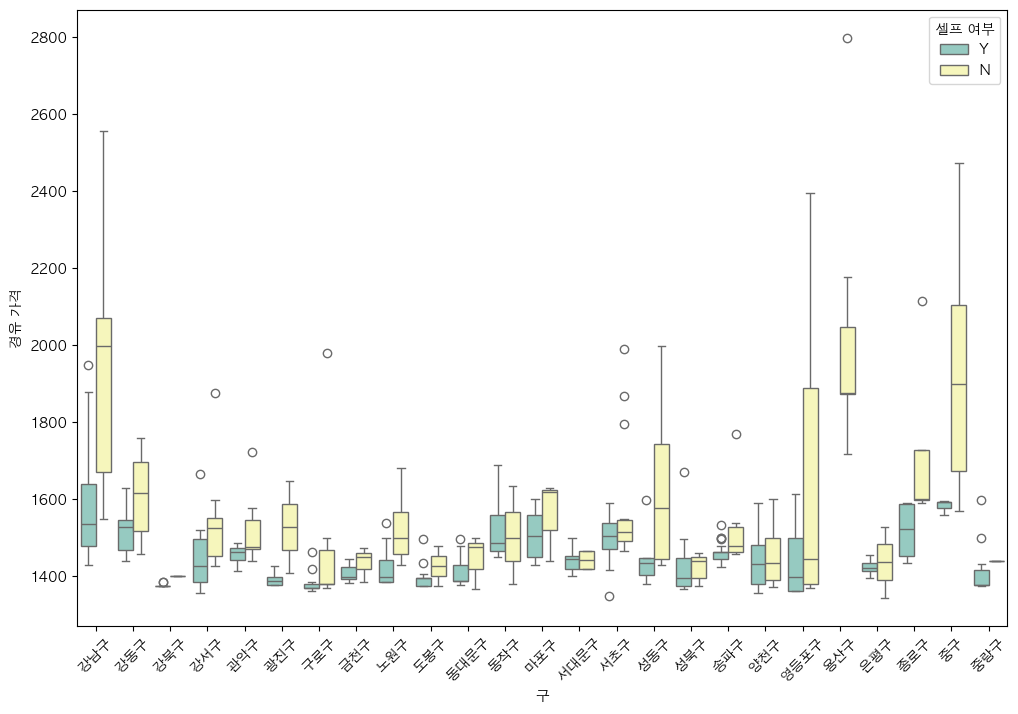

In [162]:
# 구별 경유 가격
plt.figure(figsize=(12, 8))
sns.boxplot(x='구', y='경유 가격', data=station_df, palette='Set3', hue='셀프 여부')
_, xlabels = plt.xticks(rotation=45)
plt.show()

- 구별로 보았을 때도 일반주유소보다 셀프주유소가 저렴한 것을 확인할 수 있다.
- 셀프주유소의 가격 분포가 일반주유소의 가격분포를 넘어선 구가 한 곳도 없다는 것을 알 수 있다.

## 결론
- <b>서울시 주유소의 셀프주유소 휘발유 및 경유 가격이 일반 주유소 가격에 비해 저렴하다.</b>
- 서울시 모든 구의 주유소에서 휘발유 및 경유 가격이 가장 비싼 10개의 주유소는 모두 일반 주유소이다.
- 가장 저렴한 10개의 주유소 중에 한 곳을 제외한 나머지 주유소는 모두 셀프 주유소이다.
- 브랜드별 주유소 가격 분포를 확인하였을 때, 모든 브랜드의 셀프 주유소 휘발유 및 경유 가격이 일반 주유소에 비해 낮게 형성되어있음을 알 수 있다.
- 구별 주유소 가격 분포를 확인하였을 때, 셀프 주유소의 휘발유 및 경유 가격이 일반 주유소에 비해 낮게 형성되어있음을 알 수 있다.